In [10]:
import pandas as pd
import numpy as np
import recmetrics
import matplotlib.pyplot as plt
from surprise import Reader, SVD, Dataset
from surprise.model_selection import train_test_split

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [11]:
ratings = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [12]:
#only consider ratings from users who have rated over n movies
n=1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()

In [13]:
ratings = ratings.query('userId in @users')
print ratings.shape
ratings.head(3)

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803


In [14]:
# get movie features

rated_movies = ratings.movieId.tolist()
movies = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
#movies = movies[['Action', 'Romance', 'Western', 'Comedy', 'Crime']]
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Long Tail Plot Example

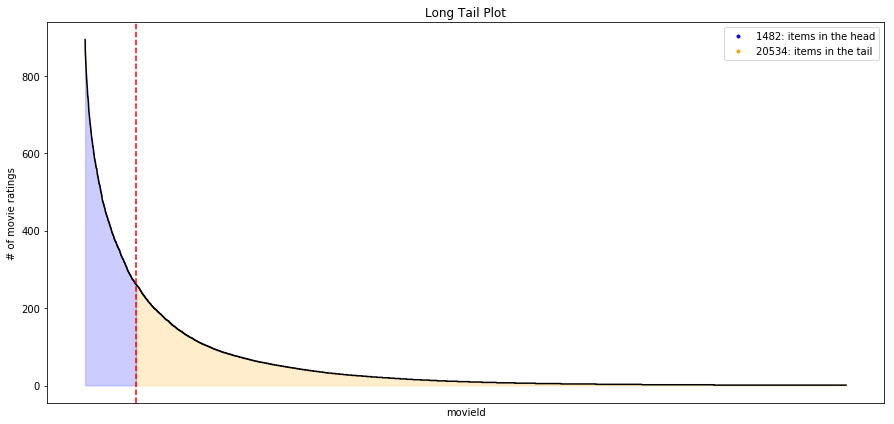

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
recmetrics.LongTailPlot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. I've implemented collaborative filtering using a SVD approach in the surprise package. The surprise package also takes care of the test train split. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

In [16]:
#format data for surprise
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [17]:
#train SVD recommender 
algo = SVD()
algo.fit(trainset)

In [18]:
#make predictions on test set. 
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
test.head()

,userId,movieId,actual,cf_predictions
0,80092,26280,3.0,3.034390
1,138254,56775,3.5,3.551611
2,131651,1939,3.0,4.254548
3,110307,3445,4.0,3.563252
4,135186,55290,4.0,3.721525


In [19]:
#evaluate model with MSE and RMSE
print recmetrics.mse(test.actual, test.cf_predictions)
print recmetrics.rmse(test.actual, test.cf_predictions)

0.2661206628985357
0.515868842729


In [20]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)

In [21]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [22]:
#get example prediction
get_users_predictions(156, 10, cf_model)

[1198, 527, 356, 2571, 1270, 1196, 5952, 589, 1784, 457]

In [23]:
#format test data
test = test.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
#make recommendations for all members in the test data
recs = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    recs.append(cf_predictions)
        
test['cf_predictions'] = recs
test.head()

/Users/clairelongo/Documents/Work/prof_dev/recmetrics/venv/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,actual,cf_predictions
userId,,
156,"[4102, 4103, 2062, 16, 2067, 4118, 23, 25, 273...","[1198, 527, 356, 2571, 1270, 1196, 5952, 589, ..."
208,"[49220, 54272, 89090, 17, 3077, 2567, 44555, 4...","[527, 1252, 3435, 1204, 3022, 3134, 926, 904, ..."
359,"[2560, 33794, 5635, 1029, 37382, 4103, 1032, 4...","[858, 260, 593, 527, 1221, 2028, 1148, 720, 58..."
394,"[6659, 33126, 8961, 5641, 1035, 56333, 527, 56...","[1208, 924, 3134, 1217, 3741, 4432, 1201, 926,..."
572,"[2, 39427, 108548, 7173, 8961, 37384, 54281, 1...","[79132, 1270, 58559, 589, 89745, 1203, 3147, 4..."


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [24]:
#make recommendations for all members in the test data
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()

recs = []
for user in test.index:
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test['pop_predictions'] = recs
test.head()

,actual,cf_predictions,pop_predictions
userId,,,
156,"[4102, 4103, 2062, 16, 2067, 4118, 23, 25, 273...","[1198, 527, 356, 2571, 1270, 1196, 5952, 589, ...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
208,"[49220, 54272, 89090, 17, 3077, 2567, 44555, 4...","[527, 1252, 3435, 1204, 3022, 3134, 926, 904, ...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
359,"[2560, 33794, 5635, 1029, 37382, 4103, 1032, 4...","[858, 260, 593, 527, 1221, 2028, 1148, 720, 58...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
394,"[6659, 33126, 8961, 5641, 1035, 56333, 527, 56...","[1208, 924, 3134, 1217, 3741, 4432, 1201, 926,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."
572,"[2, 39427, 108548, 7173, 8961, 37384, 54281, 1...","[79132, 1270, 58559, 589, 89745, 1203, 3147, 4...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ..."


# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [25]:
#make recommendations for all members in the test data

recs = []
for user in test.index:
    random_predictions = ratings.movieId.sample(10).values.tolist()
    recs.append(random_predictions)
        
test['random_predictions'] = recs
test.head()

,actual,cf_predictions,pop_predictions,random_predictions
userId,,,,
156,"[4102, 4103, 2062, 16, 2067, 4118, 23, 25, 273...","[1198, 527, 356, 2571, 1270, 1196, 5952, 589, ...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[4155, 90345, 125, 54372, 372, 88179, 3683, 14..."
208,"[49220, 54272, 89090, 17, 3077, 2567, 44555, 4...","[527, 1252, 3435, 1204, 3022, 3134, 926, 904, ...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[2143, 69, 542, 8873, 5225, 53226, 457, 3811, ..."
359,"[2560, 33794, 5635, 1029, 37382, 4103, 1032, 4...","[858, 260, 593, 527, 1221, 2028, 1148, 720, 58...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[941, 3365, 784, 6565, 5013, 1154, 1994, 5013,..."
394,"[6659, 33126, 8961, 5641, 1035, 56333, 527, 56...","[1208, 924, 3134, 1217, 3741, 4432, 1201, 926,...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[7396, 2915, 4014, 3997, 76293, 33085, 367, 42..."
572,"[2, 39427, 108548, 7173, 8961, 37384, 54281, 1...","[79132, 1270, 58559, 589, 89745, 1203, 3147, 4...","[1198, 1270, 593, 2762, 318, 2571, 260, 1240, ...","[5310, 1476, 106696, 95558, 257, 5147, 43376, ..."


# Recall

In [26]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [27]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.0007077131603229313,
 0.0011465025126773517,
 0.001498252975490369,
 0.001787349000817519,
 0.002083194018424135,
 0.0023441484956734093,
 0.0025774063843141295,
 0.002791438220546552,
 0.00300077734374763,
 0.0032347423008934634]

In [28]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.0002739101990522451,
 0.00038498924022122797,
 0.00047895338270591997,
 0.0005513321269165005,
 0.0006169979979447731,
 0.0006686584552904496,
 0.0007251744603896805,
 0.000775134039455858,
 0.0008215555764250518,
 0.0008654243522888867]

In [29]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.003078959051121187,
 0.006157918102242374,
 0.009236877153363562,
 0.012315836204484749,
 0.015394795255605939,
 0.018473754306727125,
 0.021552713357848315,
 0.024631672408969497,
 0.027710631460090684,
 0.030789590511211877]

# Mark Plot

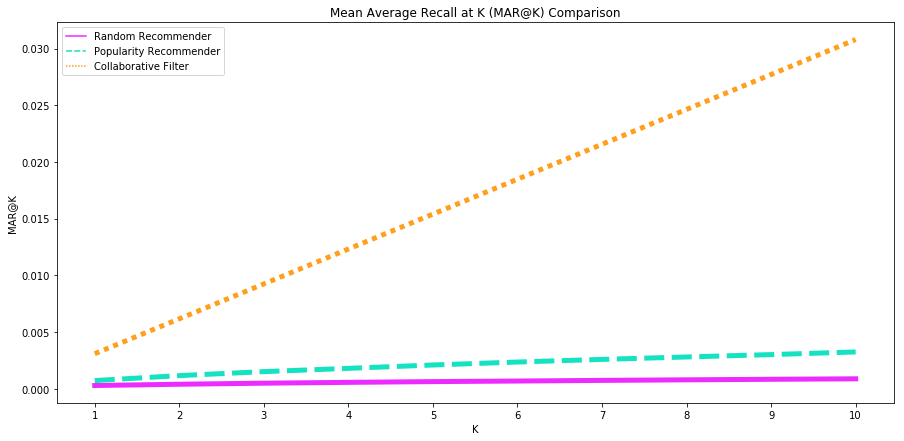

In [30]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.MarkPlot(mark_scores, model_names=names, k_range=index)

# Coverage

In [31]:
catalog = ratings.movieId.unique().tolist()
random_coverage = recmetrics.coverage(random_predictions, catalog)
pop_coverage = recmetrics.coverage(pop_predictions, catalog)
cf_coverage = recmetrics.coverage(cf_predictions, catalog)

# Coverage Plot

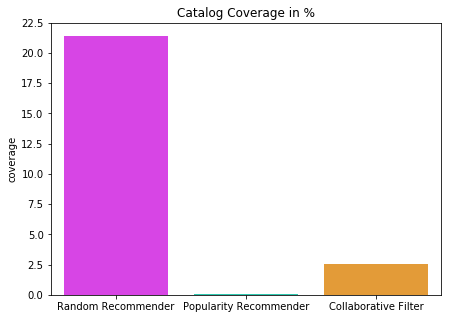

In [32]:
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.CoveragePlot(coverage_scores, model_names)

# Personalization

In [33]:
example_predictions = [
    ['1', '2', 'C', 'D'],
    ['4', '3', 'm', 'X'],
    ['7', 'B', 't', 'X']
]

In [34]:
recmetrics.personalization(predicted=example_predictions)

0.9166666666666666

# Intra-list Similarity

In [35]:
example_predictions = [
    [3, 7, 5, 9],
    [9, 6, 12, 623],
    [7, 894, 6, 623]
]

In [36]:
feature_df = movies[['Action', 'Comedy', 'Romance']]

In [37]:
recmetrics.intra_list_similarity(example_predictions, feature_df)

0.27777777777777773

# Classification Probability Plot

In [38]:
#make fake classification probability data
class_one_probs = np.random.normal(loc=.7, scale=0.1, size=1000)
class_zero_probs = np.random.normal(loc=.3, scale=0.1, size=1000)
actual = [1] * 1000
class_zero_actual = [0] * 1000
actual.extend(class_zero_actual)

pred_df = pd.DataFrame([np.concatenate((class_one_probs, class_zero_probs), axis=None), actual]).T
pred_df.columns = ["probability", "truth"]
pred_df.head()

,probability,truth
0,0.685577,1.0
1,0.697524,1.0
2,0.730575,1.0
3,0.614448,1.0
4,0.837646,1.0


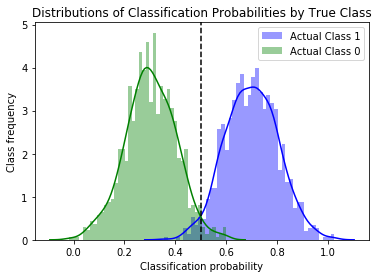

In [39]:
recmetrics.ClassDistributionPlot(pred_df, n_bins=45)

# ROC Plot

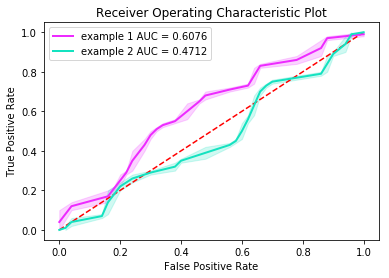

In [42]:
model_probs = [np.random.normal(loc=.7, scale=0.1, size=100), np.random.normal(loc=.4, scale=0.1, size=100)]
model_names = ["example 1", "example 2"]
actual = [1] * 50
class_zero_actual = [0] * 50
actual.extend(class_zero_actual)

recmetrics.ROCPlot(actual, model_probs, model_names)

# Rank Order Analysis 

In [ ]:
coming soon....